In [3]:
using TCI4Keldysh
using PythonPlot
using PythonCall
using MAT
using LinearAlgebra

INCH_TO_PT = 72
PT_TO_INCH = 1.0/INCH_TO_PT
COLUMN_PT = 432
COLUMN_INCH = COLUMN_PT*PT_TO_INCH
PLOT_COLUMN_PT = 420
PLOT_COLUMN_INCH = PLOT_COLUMN_PT*PT_TO_INCH
PLOT_PAGE_PT = PLOT_COLUMN_PT*2
PLOT_PAGE_INCH = PLOT_PAGE_PT*PT_TO_INCH


# setup
channel = "t"
base_path = "SIAM_u=0.50"
PSFpath = joinpath(TCI4Keldysh.datadir(), "SIAM_u=0.50/PSF_nz=4_conn_zavg/")
Vpath = joinpath(TCI4Keldysh.datadir(), "SIAM_u=0.50", "V_KF_" * TCI4Keldysh.channel_translate(channel))
flavor = 1

┌ Warning: Replacing docs for `TCI4Keldysh.TuckerDecomposition :: Union{Tuple{Int64, Int64, Int64}, Tuple{T}} where T` in module `TCI4Keldysh`
└ @ Base.Docs docs/Docs.jl:243


size of Σ_vec:(200,)
size of Σ_slanted: (101, 100)
size of Σ_vec:(200,)
size of Σ_slanted: (101, 100)


1

In [4]:
# load MuNRG
# In the MuNRG data, the Keldysh components of Σ are stored on a 4-fold duplicated 1D grid,
# in the order: (11) (21) (12) (22)
# MuNRG code: Multipoint/get_V_4pIE.m; ses asymmetricIE
Σnames = ["SE_KF_$i.mat" for i in 1:4]
Σs = Vector{ComplexF64}[]
grids = Vector{Float64}[]
for Σname in Σnames
    matopen(joinpath(Vpath, Σname), "r") do f
        CFdat = read(f, "CFdat")
        Σ_act = CFdat["Ggrid"][flavor]
        grid_act = CFdat["ogrid"][flavor]
        push!(Σs, vec(Σ_act))
        push!(grids, vec(real.(grid_act)))
    end
end
@show size.(Σs)
@show size.(grids)
# check whether all frequency grids are the same
@assert all(length.(grids) .== length(first(grids)))
for g in grids[2:4]
    @assert maximum(abs.(g .- grids[1])) < 1.e-12
end


size.(Σs) = [(1604,), (1604,), (1604,), (1604,)]
size.(grids) = [(401,), (401,), (401,), (401,)]


set parameters

In [5]:
(γ, sigmak) = TCI4Keldysh.read_broadening_params(base_path; channel=channel)
broadening_kwargs = TCI4Keldysh.read_broadening_settings(joinpath(TCI4Keldysh.datadir(), base_path); channel=channel)
# cf. MuNRG/Multipoint/subroutines/getGgrid_KF.m, l. 119
broadening_kwargs[:estep] = 50
broadening_kwargs[:emin] = 1.e-6
broadening_kwargs[:emax] = 1e4
omsig = grids[1]
flavor_idx = flavor

T = TCI4Keldysh.dir_to_T(PSFpath)

0.0005

Julia fdt/no fdt combinations

In [17]:
# Julia, calculate everything seperately
ωconvMat = TCI4Keldysh.ωconvMat_K1()
# precompute correlators
G = TCI4Keldysh.FullCorrelator_KF(PSFpath, ["F1", "F1dag"]; T, flavor_idx=flavor_idx, ωs_ext=(omsig,), ωconvMat=ωconvMat, sigmak=sigmak, γ, broadening_kwargs...)
G_aux_L = TCI4Keldysh.FullCorrelator_KF(PSFpath, ["F1", "Q1dag"]; T, flavor_idx=flavor_idx, ωs_ext=(omsig,), ωconvMat=ωconvMat, sigmak=sigmak, γ, broadening_kwargs...)
G_aux_R = TCI4Keldysh.FullCorrelator_KF(PSFpath, ["Q1", "F1dag"]; T, flavor_idx=flavor_idx, ωs_ext=(omsig,), ωconvMat=ωconvMat, sigmak=sigmak, γ, broadening_kwargs...)
G_data = TCI4Keldysh.precompute_all_values(G)
G_aux_L_data = TCI4Keldysh.precompute_all_values(G_aux_L)
G_aux_R_data = TCI4Keldysh.precompute_all_values(G_aux_R)

# G_data_fdt = TCI4Keldysh.precompute_all_values_FDT(PSFpath, ["F1", "F1dag"], omsig; flavor_idx=flavor_idx, T=T, γ=γ, sigmak=sigmak, broadening_kwargs...)
# G_aux_L_data_fdt = TCI4Keldysh.precompute_all_values_FDT(PSFpath, ["F1", "Q1dag"], omsig; flavor_idx=flavor_idx, T=T, γ=γ, sigmak=sigmak, broadening_kwargs...)
# G_aux_R_data_fdt = TCI4Keldysh.precompute_all_values_FDT(PSFpath, ["Q1", "F1dag"], omsig; flavor_idx=flavor_idx, T=T, γ=γ, sigmak=sigmak, broadening_kwargs...)


# deduce self-energies
X = TCI4Keldysh.get_PauliX()
I = diagm([1.0,1.0])
Σ_L = zeros(ComplexF64, size(G_data))
for i in axes(Σ_L,1)
    Σ_L[i,:,:] .= X*G_aux_L_data[i,:,:]/G_data[i,:,:]
end
Σ_R = zeros(ComplexF64, size(G_data))
for i in axes(Σ_R,1)
    Σ_R[i,:,:] .= (I/G_data[i,:,:]) * G_aux_R_data[i,:,:] * X
end


Loading stuff:   0.001794 seconds (454 allocations: 201.477 KiB)
Creating Broadened PSFs:  11.723455 seconds (13.62 M allocations: 27.737 GiB, 13.55% gc time)
All the rest:   0.592419 seconds (173.92 k allocations: 1.135 GiB, 2.14% gc time)
Loading stuff:   0.001415 seconds (454 allocations: 201.477 KiB)
Creating Broadened PSFs:  11.642739 seconds (13.62 M allocations: 27.737 GiB, 13.53% gc time)
All the rest:   0.649476 seconds (174.74 k allocations: 1.140 GiB, 2.69% gc time)
Loading stuff:   0.001352 seconds (454 allocations: 201.477 KiB)
Creating Broadened PSFs:  11.176785 seconds (13.62 M allocations: 27.737 GiB, 11.40% gc time)
All the rest:   0.673921 seconds (174.74 k allocations: 1.140 GiB, 1.37% gc time)


In [23]:
Lwidth = [0.0005, 0.0015]
Lw_p = Lwidth
# Lw_p = reverse(Lwidth)
nO = 2
Lw_mat = zeros(nO,nO-1)
for it1 in 1:nO
    Lw_mat[it1,it1:end] = reverse(cumsum(reverse(Lw_p[it1+1:end])));
    Lw_mat[it1,1:it1-1] = cumsum(Lw_p[1:it1-1]);
end
display(Lw_mat)

2×1 Matrix{Float64}:
 0.0015
 0.0005

In [15]:
    # Σ for fdt
Σ_L_fdt = zeros(ComplexF64, size(G_data_fdt))
for i in axes(Σ_L,1)
    Σ_L_fdt[i,:,:] .= X*G_aux_L_data_fdt[i,:,:]/G_data_fdt[i,:,:]
end
Σ_R_fdt = zeros(ComplexF64, size(G_data_fdt))
for i in axes(Σ_R,1)
    Σ_R_fdt[i,:,:] .= (I/G_data_fdt[i,:,:]) * G_aux_R_data_fdt[i,:,:] * X
end
    # Σ "mixed"
Σ_L_ab = zeros(ComplexF64, size(G_data_fdt))
for i in axes(Σ_L,1)
    Σ_L_ab[i,:,:] .= X*G_aux_L_data[i,:,:]/G_data_fdt[i,:,:]
end
Σ_R_ab = zeros(ComplexF64, size(G_data_fdt))
for i in axes(Σ_R,1)
    Σ_R_ab[i,:,:] .= (I/G_data_fdt[i,:,:]) * G_aux_R_data[i,:,:] * X
end

Σ_L_ba = zeros(ComplexF64, size(G_data_fdt))
for i in axes(Σ_L,1)
    Σ_L_ba[i,:,:] .= X*G_aux_L_data_fdt[i,:,:]/G_data[i,:,:]
end
Σ_R_ba = zeros(ComplexF64, size(G_data_fdt))
for i in axes(Σ_R,1)
    Σ_R_ba[i,:,:] .= (I/G_data[i,:,:]) * G_aux_R_data_fdt[i,:,:] * X
end

UndefVarError: UndefVarError: `G_data_fdt` not defined

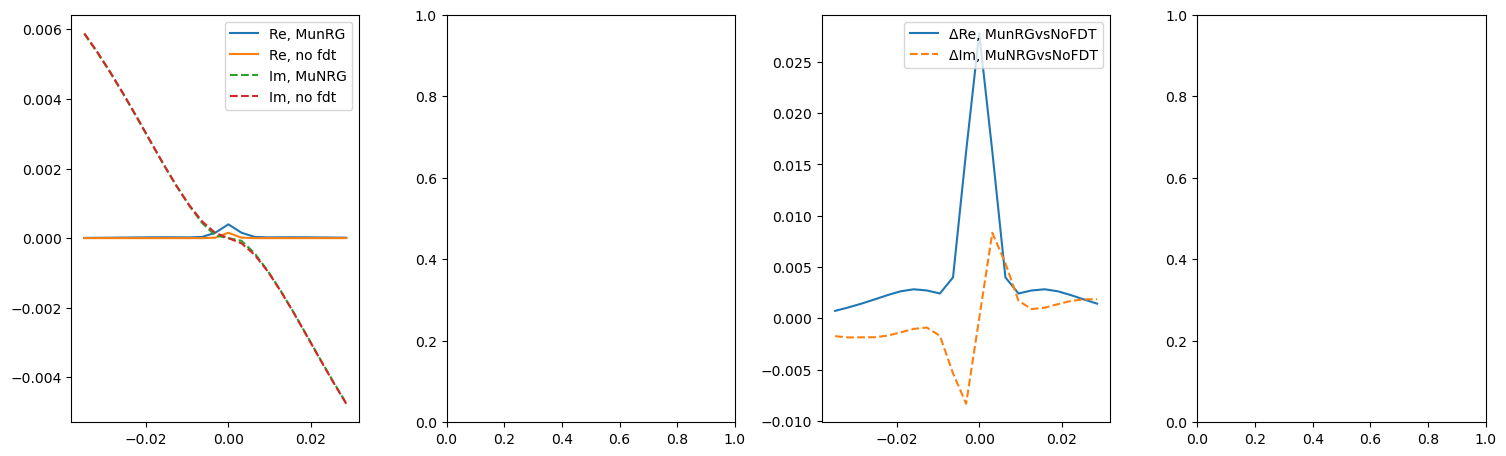

In [14]:
# plot self-energies; biggest discrepancy in MuNRG vs Julia is in k=(11) component of Σ

fig, axs = subplots(1,4, figsize=(1.3*PLOT_PAGE_INCH, PLOT_PAGE_INCH*4/10))

window = 190:210
omsig = grids[1]
sig = Σs[1][1 : length(omsig)]
omsig = omsig[window]
axs[0].plot(omsig, real.(sig[window]),  label="Re, MunRG")
axs[0].plot(omsig, real.(Σ_L[window, 1, 1]),  label="Re, no fdt")
# axs[0].plot(omsig, real.(Σ_L_fdt[window, 1, 1]),  label="Re, fdt")
axs[0].plot(omsig, imag.(sig[window]),  linestyle="dashed",  label="Im, MuNRG")
axs[0].plot(omsig, imag.(Σ_L[window, 1, 1]),  linestyle="dashed",  label="Im, no fdt")
# axs[0].plot(omsig, imag.(Σ_L_fdt[window, 1, 1]),  linestyle="dashed",  label="Im, fdt")
axs[0].legend()

# errors
nn = maximum(abs.(Σ_L))
# dFDT = (Σ_L .- Σ_L_fdt) ./ nn
dMat = (sig .- Σ_L) ./ nn
# dMatFDT = (sig .- Σ_L_fdt) ./ nn

# axs[1].set_yscale("log")
# axs[1].plot(omsig, (real.(dFDT[window, 1, 1])),  label="ΔRe, FDTvsNoFDT")
# axs[1].plot(omsig, (imag.(dFDT[window, 1, 1])),  linestyle="dashed",  label="ΔIm, FDTvsNoFDT")
# axs[1].legend()


nn = maximum(abs.(Σ_L[:,1,1]))
# dFDT = (Σ_L .- Σ_L_fdt) ./ nn
dMat = (sig .- Σ_L) ./ nn
# dMatFDT = (sig .- Σ_L_fdt) ./ nn
axs[2].plot(omsig, (real.(dMat[window, 1, 1])),  label="ΔRe, MunRGvsNoFDT")
axs[2].plot(omsig, (imag.(dMat[window, 1, 1])),  linestyle="dashed",  label="ΔIm, MuNRGvsNoFDT")
# axs[1].set_yscale("log")
axs[2].legend()

# axs[3].plot(omsig, (real.(dMatFDT[window, 1, 1])),  label="ΔRe, MunRGvsFDT")
# axs[3].plot(omsig, (imag.(dMatFDT[window, 1, 1])),  linestyle="dashed",  label="ΔIm, MuNRGvsFDT")
# axs[3].legend()

fig.tight_layout()
display(fig)
# idx = 201
# display(G_aux_L_data[idx,:,:])
# display(G_aux_L_data_fdt[idx,:,:])
# display(inv(G_data[idx,:,:]))
# display(inv(G_data_fdt[idx,:,:]))
# display(X * G_aux_L_data[idx,:,:] * inv(G_data[idx,:,:]))
# display(X * G_aux_L_data_fdt[idx,:,:] * inv(G_data_fdt[idx,:,:]))

The reason for the discrepancy between Julia and MuNRG in $\Re(\Sigma^{(11)})$ around $\omega=0$, which is the biggest error,
lies in the fact that in MuNRG $\Re(\Sigma^{(11)})\neq 0$, which is forbidden by the FDT.

Looking at $\Sigma_L^{(11)}(\omega=0)$, we see that $G_{aux}^{(22)}(\omega=0)\neq 0$ if $G_{aux}$ is computed without FDT. This leads
to two nonzero numbers being multiplied in $\Sigma_L^{(11)}(\omega=0)$.

Let's compare MuNRG with calc_Σ_KF_aIE_viaR

In [35]:
# what is actually used in the code
(Σ_LJ, Σ_RJ) = TCI4Keldysh.calc_Σ_KF_aIE_viaR(PSFpath, omsig; flavor_idx=flavor_idx, T=T, sigmak=sigmak, γ=γ, broadening_kwargs...)
@show size(Σ_LJ)

Loading stuff:   0.001788 seconds (446 allocations: 339.297 KiB)
Loading stuff:   0.001549 seconds (446 allocations: 339.297 KiB)
Loading stuff:   0.001474 seconds (446 allocations: 339.297 KiB)
size(Σ_LJ) = (401, 2, 2)


(401, 2, 2)

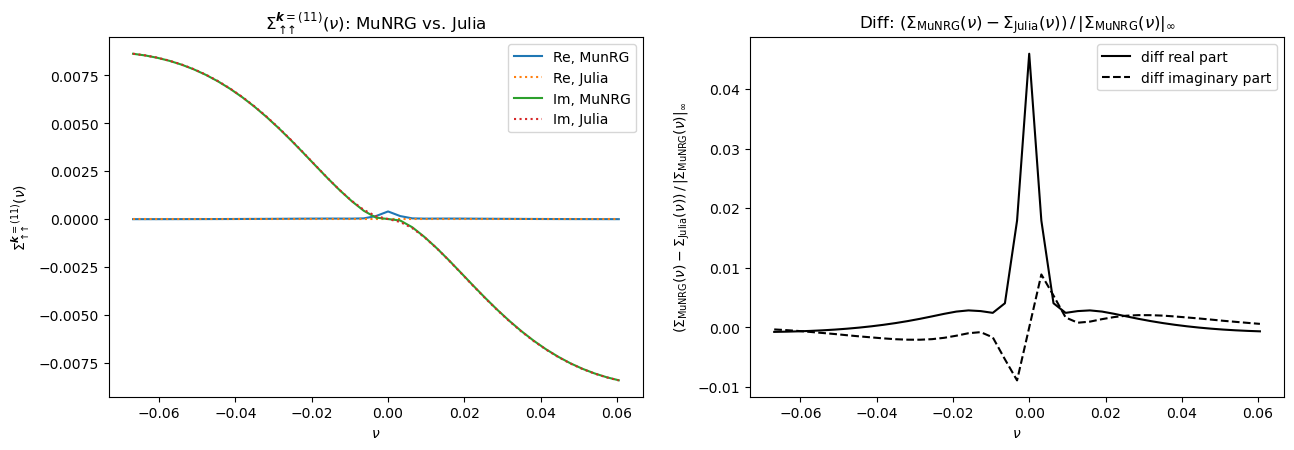

In [ ]:
fig, axs = subplots(1,2, figsize=(1.3*PLOT_PAGE_INCH, PLOT_PAGE_INCH*4/10))

window = 180:220
omsig = grids[1]
sig = Σs[1][1 : length(omsig)]
omsigp = omsig[window]
axs[0].plot(omsigp, real.(sig[window]), label="Re, MunRG")
axs[0].plot(omsigp, real.(Σ_LJ[window, 1, 1]), linestyle=":", label="Re, Julia")
axs[0].plot(omsigp, imag.(sig[window]), label="Im, MuNRG")
axs[0].plot(omsigp, imag.(Σ_LJ[window, 1, 1]),  linestyle=":",  label="Im, Julia")
axs[0].legend()
axs[0].set_xlabel(L"\nu")
axs[1].set_xlabel(L"\nu")

dMuRNRG_J = sig[window] .- Σ_LJ[window,1,1]
dmax = maximum(abs.(sig[window]))
dMuRNRG_J ./= dmax
axs[1].plot(omsigp, real.(dMuRNRG_J), color="black", label="diff real part")
axs[1].plot(omsigp, imag.(dMuRNRG_J), color="black", linestyle="dashed",  label="diff imaginary part")
axs[1].legend()

axs[0].set_xlabel(L"\nu")
axs[0].set_ylabel(L"\Sigma^{\boldsymbol{k}=(11)}_{\uparrow\!\!\!\uparrow}(\nu)")
axs[1].set_ylabel(L"$(\Sigma_{\mathrm{MuNRG}}(\nu) - \Sigma_{\mathrm{Julia}}(\nu))\,/\,|\Sigma_{\mathrm{MuNRG}}(\nu)|_\infty$")
axs[1].set_xlabel(L"\nu")
axs[0].set_title(L"$\Sigma^{\boldsymbol{k}=(11)}_{\uparrow\!\!\!\uparrow}(\nu)$: MuNRG vs. Julia")
axs[1].set_title(L"Diff: $(\Sigma_{\mathrm{MuNRG}}(\nu) - \Sigma_{\mathrm{Julia}}(\nu))\,/\,|\Sigma_{\mathrm{MuNRG}}(\nu)|_\infty$")

savefig("sigma_munrg_vs_julia_$(length(window)).pdf")
display(fig)

Check out Green's function and spectral functions

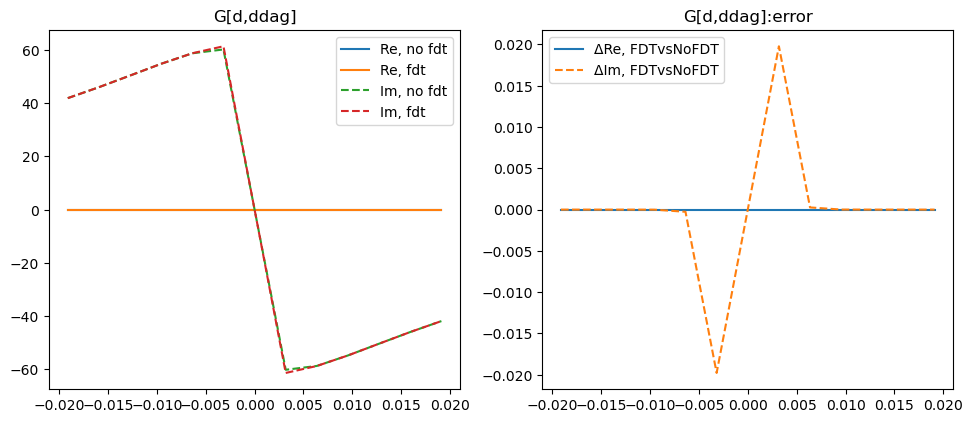

In [73]:
# plot impurity Green's function; biggest discrepancy in MuNRG vs Julia is in k=(11) component of Σ

fig, axs = subplots(1,2, figsize=(PLOT_PAGE_INCH, PLOT_PAGE_INCH*4/10))

window = 195:207
omsig = grids[1]
omsig = omsig[window]

axs[0].plot(omsig, real.(G_data[window, 2,2]),  label="Re, no fdt")
axs[0].plot(omsig, real.(G_data_fdt[window, 2,2]),  label="Re, fdt")
axs[0].plot(omsig, imag.(G_data[window, 2,2]),  linestyle="dashed",  label="Im, no fdt")
axs[0].plot(omsig, imag.(G_data_fdt[window, 2,2]),  linestyle="dashed",  label="Im, fdt")
axs[0].set_title("G[d,ddag]")
axs[0].legend()

# errors
nn = maximum(abs.(G_data))
dFDT = (G_data .- G_data_fdt) ./ nn
axs[1].plot(omsig, (real.(dFDT[window, 2,2])),  label="ΔRe, FDTvsNoFDT")
axs[1].plot(omsig, (imag.(dFDT[window, 2,2])),  linestyle="dashed",  label="ΔIm, FDTvsNoFDT")
# axs[1].set_yscale("log")
axs[1].set_title("G[d,ddag]:error")
axs[1].legend()

display(fig)

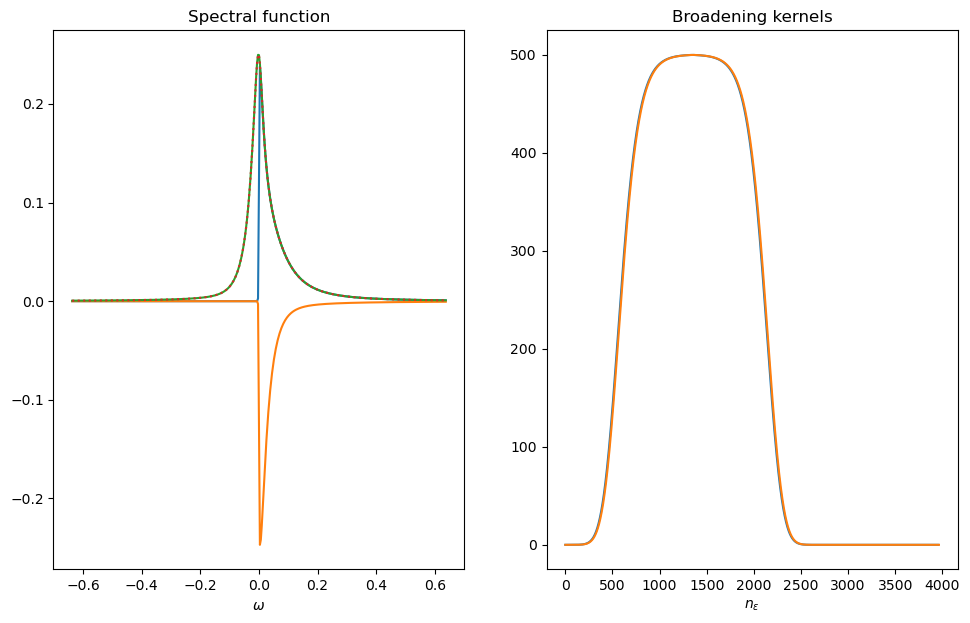

size(G_aux_L.GR_to_GK) = (2, 4, 2)
G_aux_L.Gp_to_G = [1.0, -1.0]
(G_aux_L.Gps[1]).ωconvMat = [1;;]
(G_aux_L.Gps[2]).ωconvMat = [-1;;]
(-2π) * (A12[201] + A21[201]) = 0.0048318140102390755
(G_aux_L.ωs_ext[1])[201] = 0.0
size(omdisc) = (5909,)
omdisc[div(length(omdisc), 2) + 1] = 0.0


0.0

In [170]:
@show size(G_aux_L.GR_to_GK)
# display(G_aux_L.GR_to_GK[:,:,1])
# display(G_aux_L.GR_to_GK[:,:,2])
@show G_aux_L.Gp_to_G
@show G_aux_L.Gps[1].ωconvMat
@show G_aux_L.Gps[2].ωconvMat

# idx = 202
# display(sig[idx])
# display(Σ_L[idx,1,1])
# display(Σ_L_fdt[idx,1,1])

# examine partial spectral functions at ω=0
Gp12 = G_aux_L.Gps[1].tucker
A12 = -1/π * imag.(Gp12.legs[1] * Gp12.center)
Gp21 = G_aux_L.Gps[2].tucker
A21 = -1/π * imag.(Gp21.legs[1] * Gp21.center)

fig, ax = subplots(1,2, figsize=(PLOT_PAGE_INCH, 3/5 * PLOT_PAGE_INCH))
ax[0].plot(G_aux_L.ωs_ext[1], A12, label="A12")
ax[0].plot(G_aux_L.ωs_ext[1], A21, label="A21")
ax[0].plot(G_aux_L.ωs_ext[1], -reverse(A21) .+ A12, label="A12(ω)+A21(-ω)")
ax[0].plot(G_aux_L.ωs_ext[1], -1/π * imag.(G_aux_L_data[:,2,1]), label="A", linestyle="dotted")
ax[0].set_xlabel(L"\omega")
ax[0].set_title("Spectral function")
# this is the value appearing in ℑ(G_aux^(22)(ω=0))
@show -2π*(A12[201] + A21[201])
# check that it's 0.0
@show G_aux_L.ωs_ext[1][201]

# plot broadening kernels at ω=0
idx = 201
ax[1].plot(-1/π * imag.(Gp12.legs[1][idx,:]))
ax[1].plot(-1/π * imag.(Gp21.legs[1][idx,:]))
ax[1].set_title("Broadening kernels")
ax[1].set_xlabel(L"n_\epsilon")
display(fig)
# @show Gp12.ωs_center[1][div(3957,2)-10:div(3957,2)+1]
omdisc = TCI4Keldysh.load_ωdisc(PSFpath, ["F1", "Q1dag"])
@show size(omdisc)
@show omdisc[div(length(omdisc),2)+1]

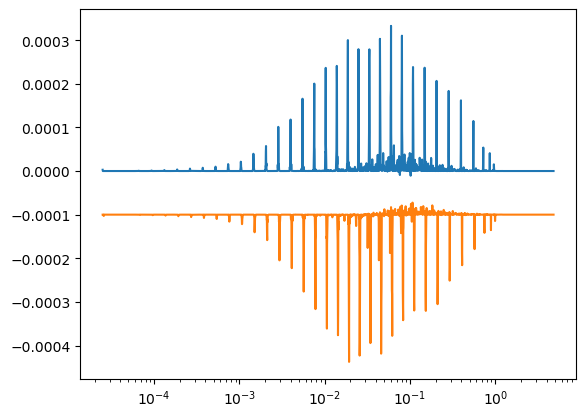

Gp12.center[omtest] = 0.00033272571883238345 + 0.0im
Gp21.center[omtest] = 1.719605821545127e-5 + 0.0im


1.719605821545127e-5 + 0.0im

In [179]:
# plot discrete PSFs
fig, ax = subplots()

Gp12 = G_aux_L.Gps[1].tucker
Gp21 = G_aux_L.Gps[2].tucker
omdisc = Gp12.ωs_center[1]
posid = [i for i in 1:length(omdisc) if omdisc[i]>0.0]
ax.plot(omdisc[posid], Gp12.center[posid])
ax.plot(omdisc[posid], Gp21.center[posid] .- 1.e-4)
ax.set_xscale("log")
display(fig)

# evaluate at same frequency
omtest = argmax(abs.(Gp12.center))
@show Gp12.center[omtest]
@show Gp21.center[omtest]

`calc_Sigma_aIE` vs MuNRG

In [5]:
# calc_Σ_KF_aIE(PSFpath::String, ω_fer::Vector{Float64}; mode::Symbol=:normal, flavor_idx::Int, sigmak::Vector{Float64}, γ::Float64, broadening_kwargs...)
(ΣaIEL, ΣaIER) = TCI4Keldysh.calc_Σ_KF_aIE(PSFpath, omsig; flavor_idx=flavor_idx, T=T, sigmak=sigmak, γ=γ, broadening_kwargs...);

Loading stuff:   0.064864 seconds (5.55 k allocations: 562.641 KiB, 77.15% compilation time)
Creating Broadened PSFs:  83.408133 seconds (52.21 M allocations: 170.960 GiB, 5.82% gc time, 6.36% compilation time)
All the rest:   2.668446 seconds (1.44 M allocations: 1.669 GiB, 13.94% gc time, 48.72% compilation time)
Loading stuff:   0.036346 seconds (454 allocations: 201.406 KiB)
Creating Broadened PSFs:  76.039954 seconds (50.56 M allocations: 170.865 GiB, 5.41% gc time)
All the rest:   0.904415 seconds (166.83 k allocations: 1.596 GiB, 1.25% gc time)
Loading stuff:   0.036510 seconds (454 allocations: 201.406 KiB)
Creating Broadened PSFs:  74.041069 seconds (50.56 M allocations: 170.865 GiB, 5.61% gc time)
All the rest:   1.237127 seconds (166.83 k allocations: 1.596 GiB, 27.35% gc time)


(ComplexF64[-1.5373729163184993e-20 + 0.0005513487789833458im 0.023884159671032947 + 0.00027567438949167275im; -1.9549575894917088e-20 + 0.0005569970859655473im 0.023879199697700772 + 0.0002784985429827735im; … ; -1.3883525482777513e-20 - 0.0005569970859655336im 0.02612080030229919 + 0.0002784985429827667im; -5.689657239021856e-21 - 0.0005513487789833312im 0.02611584032896702 + 0.0002756743894916655im;;; 0.023884159671032947 - 0.00027567438949167275im 0.0 + 0.0im; 0.023879199697700772 - 0.0002784985429827735im 0.0 + 0.0im; … ; 0.02612080030229919 - 0.0002784985429827667im 0.0 - 0.0im; 0.02611584032896702 - 0.0002756743894916655im 0.0 - 0.0im], ComplexF64[2.710505431213761e-20 + 0.0005513487789833493im 0.023884159671032943 + 0.00027567438949167443im; -1.3552527156068805e-20 + 0.0005569970859655511im 0.023879199697700776 + 0.000278498542982776im; … ; 2.710505431213761e-20 - 0.0005569970859655281im 0.026120800302299196 + 0.00027849854298276386im; 0.0 - 0.0005513487789833254im 0.0261158403

In [34]:
(ΣaIEL2, ΣaIER2) = TCI4Keldysh.calc_Σ_KF_aIE(PSFpath, omsig; flavor_idx=flavor_idx, T=T, sigmak=sigmak, γ=γ, emax=20.0, emin=2.5e-5, estep=50);

Loading stuff:   0.054937 seconds (454 allocations: 201.406 KiB)
Creating Broadened PSFs:  26.475032 seconds (13.13 M allocations: 22.744 GiB, 51.47% gc time)
All the rest:   2.290192 seconds (118.73 k allocations: 560.576 MiB, 28.98% gc time)
Loading stuff:   0.104718 seconds (454 allocations: 201.406 KiB)
Creating Broadened PSFs:  16.657499 seconds (13.13 M allocations: 22.745 GiB, 43.79% gc time)
All the rest:   1.366893 seconds (119.29 k allocations: 563.138 MiB, 47.89% gc time)
Loading stuff:   0.050106 seconds (454 allocations: 201.406 KiB)
Creating Broadened PSFs:  15.725891 seconds (13.13 M allocations: 22.745 GiB, 45.23% gc time)
All the rest:   1.345794 seconds (119.29 k allocations: 563.138 MiB, 46.84% gc time)


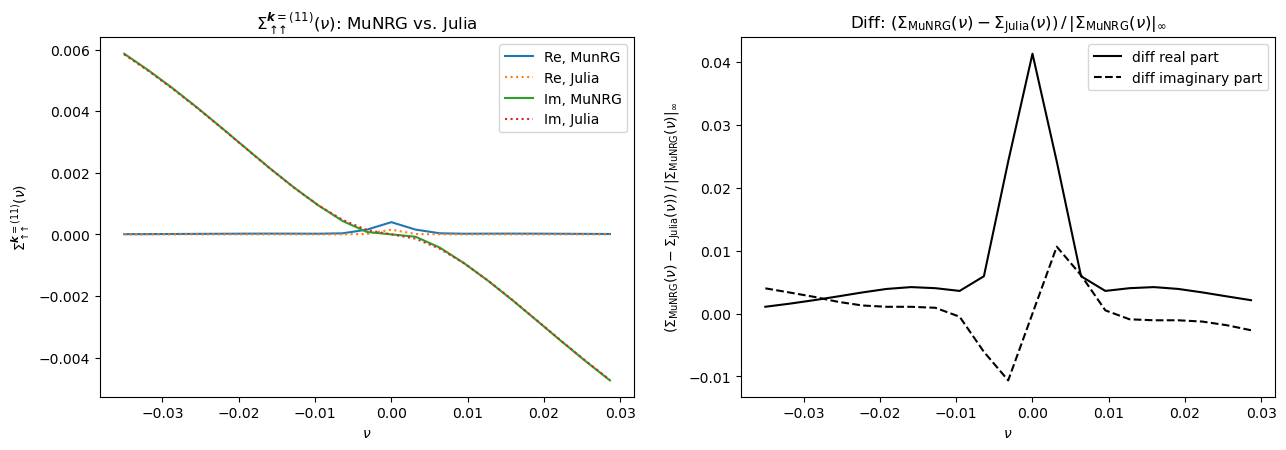

In [35]:
fig, axs = subplots(1,2, figsize=(1.3*PLOT_PAGE_INCH, PLOT_PAGE_INCH*4/10))

window = 190:210
omsig = grids[1]
sig = Σs[1][1 : length(omsig)]
omsigp = omsig[window]
axs[0].plot(omsigp, real.(sig[window]), label="Re, MunRG")
axs[0].plot(omsigp, real.(ΣaIEL2[window, 1, 1]), linestyle=":", label="Re, Julia")
axs[0].plot(omsigp, imag.(sig[window]), label="Im, MuNRG")
axs[0].plot(omsigp, imag.(ΣaIER2[window, 1, 1]),  linestyle=":",  label="Im, Julia")
axs[0].legend()
axs[0].set_xlabel(L"\nu")
axs[1].set_xlabel(L"\nu")

dMuRNRG_J = sig[window] .- ΣaIEL2[window,1,1]
dmax = maximum(abs.(sig[window]))
dMuRNRG_J ./= dmax
axs[1].plot(omsigp, real.(dMuRNRG_J), color="black", label="diff real part")
axs[1].plot(omsigp, imag.(dMuRNRG_J), color="black", linestyle="dashed",  label="diff imaginary part")
axs[1].legend()

axs[0].set_xlabel(L"\nu")
axs[0].set_ylabel(L"\Sigma^{\boldsymbol{k}=(11)}_{\uparrow\!\!\!\uparrow}(\nu)")
axs[1].set_ylabel(L"$(\Sigma_{\mathrm{MuNRG}}(\nu) - \Sigma_{\mathrm{Julia}}(\nu))\,/\,|\Sigma_{\mathrm{MuNRG}}(\nu)|_\infty$")
axs[1].set_xlabel(L"\nu")
axs[0].set_title(L"$\Sigma^{\boldsymbol{k}=(11)}_{\uparrow\!\!\!\uparrow}(\nu)$: MuNRG vs. Julia")
axs[1].set_title(L"Diff: $(\Sigma_{\mathrm{MuNRG}}(\nu) - \Sigma_{\mathrm{Julia}}(\nu))\,/\,|\Sigma_{\mathrm{MuNRG}}(\nu)|_\infty$")

savefig("sigma_munrg_vs_julia_aIE.pdf")
display(fig)

### Plot MuNRG G, G_aux

In [3]:
using HDF5

# matcfpath = "/scratch/m/M.Frankenbach/tci4keldysh/data/SIAM_u=0.50_MAT/CF_KF"
matcfpath = joinpath(TCI4Keldysh.datadir(), "SIAM_u=0.50/CF_KF")
Gfile = "CF_KF_((F1,F1dag))_Hw=0.4_Lw=0.0005_0.0015_leg1.h5"
Gaux_Lfile = "CF_KF_((F1,Q1dag))_Hw=0.4_Lw=0.0005_0.0015_leg1.h5"
Gaux_Rfile = "CF_KF_((Q1,F1dag))_Hw=0.4_Lw=0.0005_0.0015_leg1.h5"
ogrid = h5read(joinpath(matcfpath, Gfile), "ogrid");
Gvals = h5read(joinpath(matcfpath, Gfile), "Ggridreal") + im * h5read(joinpath(matcfpath, Gfile), "Ggridimag");
Gaux_Lvals = h5read(joinpath(matcfpath, Gaux_Lfile), "Ggridreal") + im * h5read(joinpath(matcfpath, Gaux_Lfile), "Ggridimag");
# Σs in second cell from above
SE1 = Σs[1][1:length(ogrid)]

SE1b = zeros(ComplexF64, length(ogrid), 2, 2)
for i in axes(SE1b, 1)
    SE1b[i,:,:] = TCI4Keldysh.get_PauliX() * Gaux_Lvals[i,:,:] / Gvals[i,:,:]
end

Compare with MuNRG self-energy

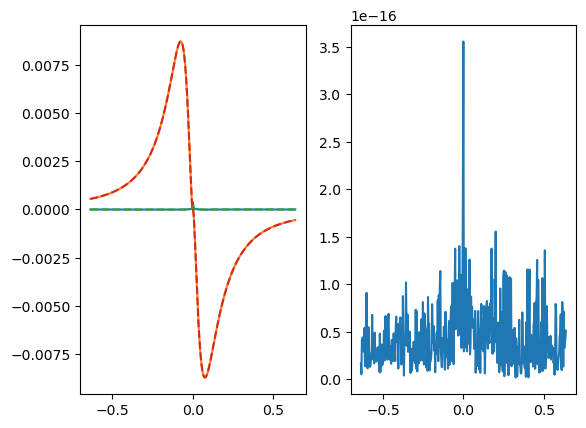

In [4]:
# plot: matches perfectly
fig, axs = subplots(1,2)

ik = (1,1)
window = 1:length(ogrid)
axs[0].plot(ogrid[window], real.(SE1[window,ik...]); label="SE1")
axs[0].plot(ogrid[window], imag.(SE1[window,ik...]); label="SE1")
axs[0].plot(ogrid[window], real.(SE1b[window,ik...]); label="SE1b", linestyle="--")
axs[0].plot(ogrid[window], imag.(SE1b[window,ik...]); label="SE1b", linestyle="--")
axs[1].plot(ogrid[window], abs.((SE1 .- SE1b)[window,ik...]))
display(fig)

Try to reproduce G, Gaux with Julia code

In [19]:
using Combinatorics

function get_GR_to_GK(D::Int) ::Array{Float64,3}
    perms = permutations(collect(1:D+1))
    GR_to_GK = zeros(D+1, (ones(Int, D+1).*2)..., factorial(D+1))
    for (ip, p) in enumerate(perms)
        for idxs in Base.Iterators.product(collect.(axes(GR_to_GK)[2:end-1])...)
            pidxs = idxs[p]
            GR_to_GK[:, idxs..., ip] .= (-1).^(1 .+ cumsum(pidxs.-1)) .* (pidxs.-1)
        end
    end
    GR_to_GK = reshape(GR_to_GK, (D+1, 2^(D+1), factorial(D+1)))
    GR_to_GK .*= 2^(-D/2+0.5)
    return GR_to_GK
end


"""
Compute correlator on grid with linear broadening that can vary between kernels.
The order of the broadening is permuted in partial correlators.
"""
function precompute_all_values_gamvec(
    PSFpath, Ops::Vector{String}, ωs_ext::Vector{Float64};
    flavor_idx::Int, T::Float64, 
    sigmak, gamvec::Vector{Float64}, broadening_kwargs...
    )
    G = zeros(ComplexF64, length(ωs_ext), 2, 2)
    @assert length(Ops)==2 "Only suitable for 2pt functions"
    @assert length(gamvec)==2 "Need two linear broadening widths"
    perms = [[1,2],[2,1]]
    isBos = TCI4Keldysh.isBosonic.(Ops)
    @assert !(xor(isBos[1], isBos[2])) "Need both operators fermionic or both bosonic"
    # compute spectral function
    ωdisc = TCI4Keldysh.load_ωdisc(PSFpath, Ops)
    Adiscs = [TCI4Keldysh.load_Adisc(PSFpath, Ops[p], flavor_idx) for p in perms]
    ωcont = TCI4Keldysh.get_Acont_grid(;broadening_kwargs...)
    println("Broaden...")
    Aconts = 
        [
        # p = [1,2]
        TCI4Keldysh.BroadenedPSF(
        ωdisc, Adiscs[1], sigmak, gamvec[2];
        ωconts=(ωcont,), broadening_kwargs...
        ),
        TCI4Keldysh.BroadenedPSF(
        ωdisc, Adiscs[1], sigmak, gamvec[1];
        ωconts=(ωcont,), broadening_kwargs...
        ),
        # p = [2,1]
        TCI4Keldysh.BroadenedPSF(
        ωdisc, Adiscs[2], sigmak, gamvec[1];
        ωconts=(ωcont,), broadening_kwargs...
        ),
        TCI4Keldysh.BroadenedPSF(
        ωdisc, Adiscs[2], sigmak, gamvec[2];
        ωconts=(ωcont,), broadening_kwargs...
        )
        ]
    println("Compute Aconts...")
    Aconts_vec = [only(Acont.legs) * Acont.center for Acont in Aconts]
    println("Compute G...")
    KKRs = [-im * π * TCI4Keldysh.my_hilbert_trafo(ωs_ext, ωcont, Acont; interpolation=:linear) for Acont in Aconts_vec]
    # ω_{\bar{1}}=-ω2
    reverse!(KKRs[3])
    reverse!(KKRs[4])
    conj!(KKRs[2])
    conj!(KKRs[4])
    G = zeros(ComplexF64, length(KKRs[1]), 2,2)
    zeta = all(isBos) ? 1 : -1
    G[:,2,1] = KKRs[1] + zeta * KKRs[4]
    G[:,1,2] = KKRs[2] + zeta * KKRs[3]
    G[:,2,2] = KKRs[1] - KKRs[2] + zeta * (KKRs[3] - KKRs[4])
    return G
end

get_GR_to_GK(1)

2×4×2 Array{Float64, 3}:
[:, :, 1] =
 0.0  1.0  0.0   1.0
 0.0  0.0  1.0  -1.0

[:, :, 2] =
 0.0  0.0  1.0   1.0
 0.0  1.0  0.0  -1.0

In [20]:
gamvec = [0.0005, 0.0015]
sigmak = [0.4]
channel = "t"
base_path = "SIAM_u=0.50"
PSFpath = joinpath(TCI4Keldysh.datadir(), "SIAM_u=0.50/PSF_nz=4_conn_zavg/")
flavor = 1

GJ = precompute_all_values_gamvec(
    PSFpath, ["F1", "F1dag"], vec(ogrid);
    flavor_idx=flavor, T=TCI4Keldysh.dir_to_T(PSFpath),
    sigmak=sigmak, gamvec=gamvec, estep=50, emin=1.e-6, emax=1.e4
    )

Gaux_LJ = precompute_all_values_gamvec(
    PSFpath, ["F1", "Q1dag"], vec(ogrid);
    flavor_idx=flavor, T=TCI4Keldysh.dir_to_T(PSFpath),
    sigmak=sigmak, gamvec=gamvec, estep=50, emin=1.e-6, emax=1.e4
    );

Broaden...
Compute Aconts...
Compute G...
Broaden...
Compute Aconts...
Compute G...


Compare code to function from this notebook

In [21]:
gamvec = [0.0005, 0.0015]
sigmak = [0.4]
channel = "t"
base_path = "SIAM_u=0.50"
PSFpath = joinpath(TCI4Keldysh.datadir(), "SIAM_u=0.50/PSF_nz=4_conn_zavg/")
flavor = 1
T = TCI4Keldysh.dir_to_T(PSFpath)

G = TCI4Keldysh.FullCorrelator_KF(
        PSFpath, ["F1", "Q1dag"];
        T=T,
        flavor_idx=flavor, ωs_ext=(vec(ogrid),), ωconvMat=TCI4Keldysh.ωconvMat_K1(), sigmak=sigmak, γ=gamvec, estep=50, emin=2.5e-5, emax=20.0
        )
GJ05ref = TCI4Keldysh.precompute_all_values(G)

GJ05 = precompute_all_values_gamvec(
        PSFpath, ["F1", "Q1dag"], vec(ogrid);
        flavor_idx=flavor, T=T,
        sigmak=sigmak, gamvec=gamvec, estep=50, emin=2.5e-5, emax=20.0
    );

Loading stuff:   0.001903 seconds (462 allocations: 202.172 KiB)
Creating Broadened PSFs:  14.685184 seconds (26.14 M allocations: 49.484 GiB, 23.73% gc time)
All the rest: SHARED between 1 and 1 ? true
SHARED between 2 and 1 ? false
SHARED between 1 and 1 ? true
SHARED between 2 and 1 ? false
  0.572761 seconds (238.43 k allocations: 1.106 GiB, 10.46% gc time)
Broaden...
Compute Aconts...
Compute G...


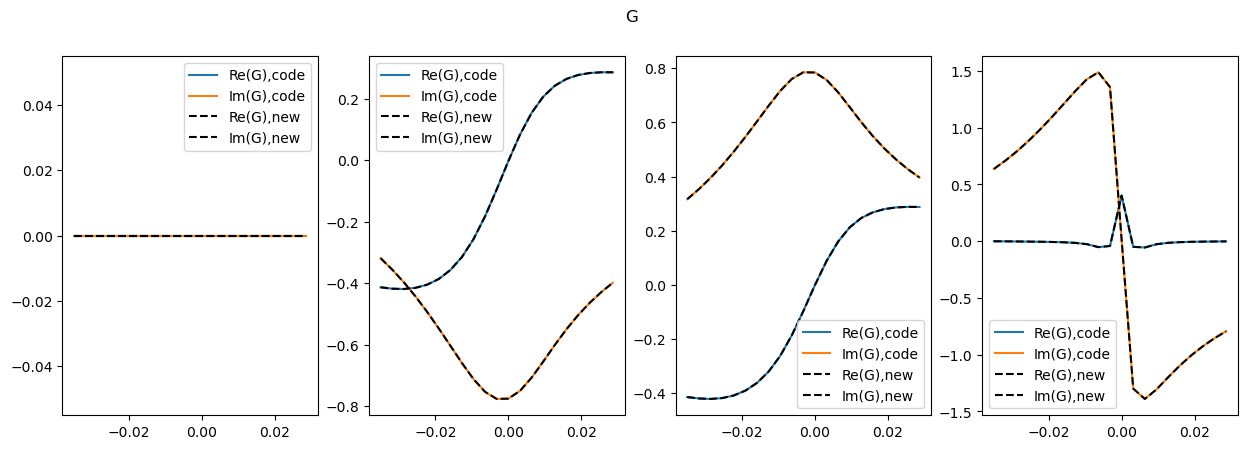

In [22]:
# all components GR
fig, axs = subplots(1,4, figsize=(1.3 * PLOT_PAGE_INCH, 0.4 * PLOT_PAGE_INCH))
window = 190:210
for ik in 1:4
    k = TCI4Keldysh.KF_idx(ik, 1)
    axs[ik-1].plot(ogrid[window], real.(GJ05ref[window,k...]); label="Re(G),code")
    axs[ik-1].plot(ogrid[window], imag.(GJ05ref[window,k...]); label="Im(G),code")
    axs[ik-1].plot(ogrid[window], real.(GJ05[window,k...]); label="Re(G),new", linestyle="--", color="black")
    axs[ik-1].plot(ogrid[window], imag.(GJ05[window,k...]); label="Im(G),new", linestyle="--", color="black")
    axs[ik-1].legend()
end
fig.suptitle("G")
display(fig)

Compare Julia to MuNRG

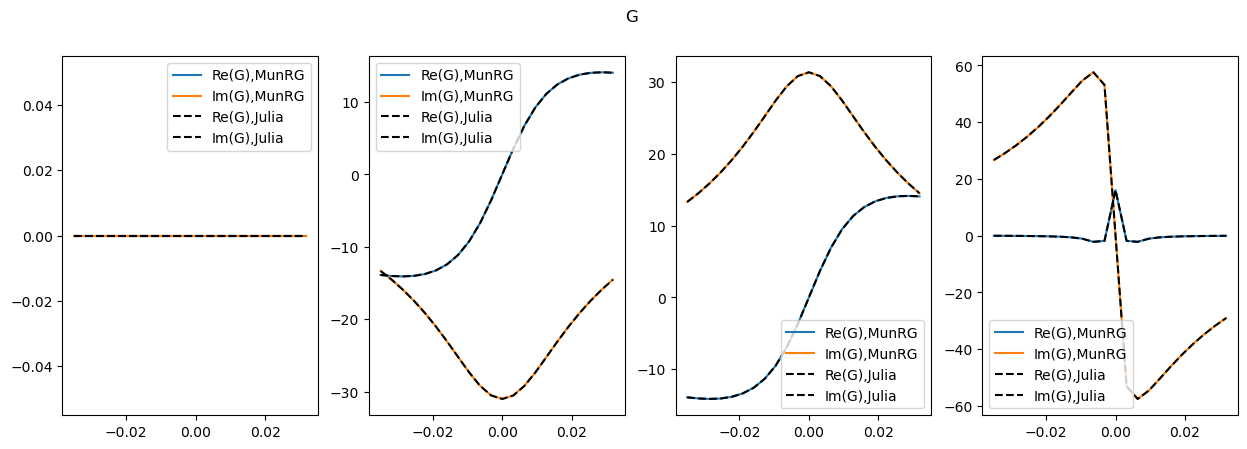

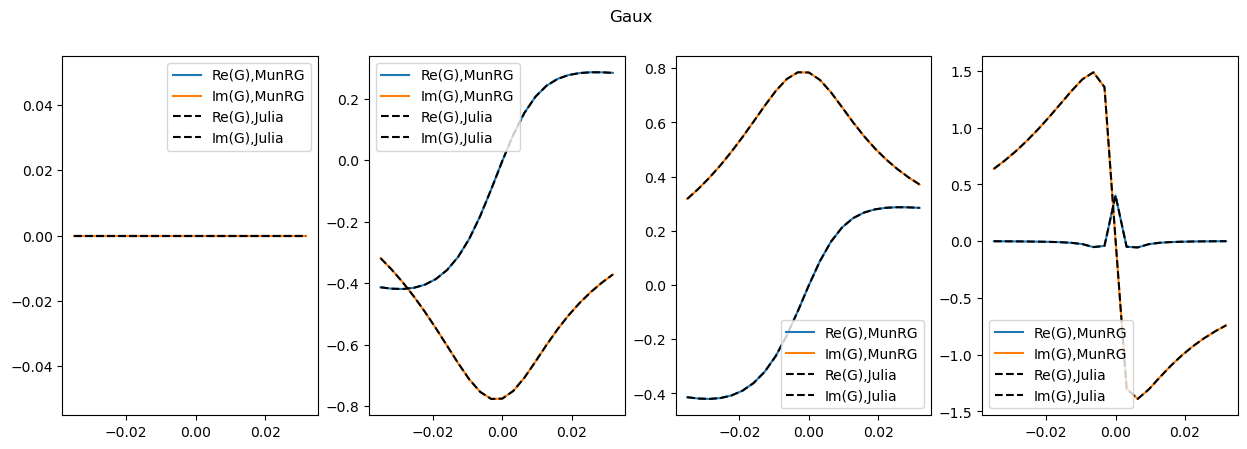

In [23]:
window = 190:211
# GJ_cheat = copy(GJ)
# GJ_cheat[:,1,2] = conj.(GJ[:,2,1])
# GJ_cheat[:,2,1] = conj.(GJ[:,1,2])
# GJ_cheat[:,2,2] = -reverse(GJ[:,2,2])
fig, axs = subplots(1,4, figsize=(1.3 * PLOT_PAGE_INCH, 0.4 * PLOT_PAGE_INCH))
for ik in 1:4
    k = TCI4Keldysh.KF_idx(ik, 1)
    axs[ik-1].plot(ogrid[window], real.(Gvals[window,k...]); label="Re(G),MunRG")
    axs[ik-1].plot(ogrid[window], imag.(Gvals[window,k...]); label="Im(G),MunRG")
    axs[ik-1].plot(ogrid[window], real.(GJ[window,k...]); label="Re(G),Julia", linestyle="--", color="black")
    axs[ik-1].plot(ogrid[window], imag.(GJ[window,k...]); label="Im(G),Julia", linestyle="--", color="black")
    axs[ik-1].legend()
end
fig.suptitle("G")
display(fig)

# Gaux_cheat = copy(Gaux_LJ)
# Gaux_cheat[:,1,2] = conj.(Gaux_LJ[:,2,1])
# Gaux_cheat[:,2,1] = conj.(Gaux_LJ[:,1,2])
# Gaux_cheat[:,2,2] = -reverse(Gaux_LJ[:,2,2])
fig2, axs2 = subplots(1,4, figsize=(1.3 * PLOT_PAGE_INCH, 0.4 * PLOT_PAGE_INCH))
for ik in 1:4
    k = TCI4Keldysh.KF_idx(ik, 1)
    axs2[ik-1].plot(ogrid[window], real.(Gaux_Lvals[window,k...]); label="Re(G),MunRG")
    axs2[ik-1].plot(ogrid[window], imag.(Gaux_Lvals[window,k...]); label="Im(G),MunRG")
    axs2[ik-1].plot(ogrid[window], real.(Gaux_LJ[window,k...]); label="Re(G),Julia", linestyle="--", color="black")
    axs2[ik-1].plot(ogrid[window], imag.(Gaux_LJ[window,k...]); label="Im(G),Julia", linestyle="--", color="black")
    axs2[ik-1].legend()
end
fig2.suptitle("Gaux")
display(fig2)

Compare self-energies

In [15]:
omsig = grids[1]
SE1 = Σs[1][1:length(omsig)]
SE2 = Σs[2][1:length(omsig)];

In [12]:

# SE1J = zeros(ComplexF64, length(ogrid), 2, 2)
# for i in axes(SE1J, 1)
#     SE1J[i,:,:] = TCI4Keldysh.get_PauliX() * Gaux_LJ[i,:,:] / GJ[i,:,:]
# end
SELJ, SERJ = TCI4Keldysh.calc_Σ_KF_aIE(PSFpath, omsig; estep=50, emin=1.e-6, emax=1.e4, T=T, flavor_idx=flavor, γ=γ, sigmak=sigmak)

Loading stuff:   0.002824 seconds (462 allocations: 202.172 KiB)
Creating Broadened PSFs:  19.038866 seconds (27.13 M allocations: 60.320 GiB, 25.58% gc time, 0.02% compilation time: 100% of which was recompilation)
All the rest:   1.041378 seconds (347.57 k allocations: 2.282 GiB, 11.98% gc time)
Loading stuff:   0.001700 seconds (462 allocations: 202.172 KiB)
Creating Broadened PSFs:  18.979335 seconds (27.12 M allocations: 60.319 GiB, 25.32% gc time)
All the rest:   1.166947 seconds (347.57 k allocations: 2.282 GiB, 24.95% gc time)
Loading stuff:   0.003156 seconds (462 allocations: 202.172 KiB)
Creating Broadened PSFs:  18.250808 seconds (27.12 M allocations: 60.320 GiB, 24.26% gc time)
All the rest:   1.003398 seconds (349.20 k allocations: 2.292 GiB, 13.39% gc time)
Loading stuff:   0.003187 seconds (462 allocations: 202.172 KiB)
Creating Broadened PSFs:  18.327478 seconds (27.12 M allocations: 60.320 GiB, 24.54% gc time)
All the rest:   0.962386 seconds (349.20 k allocations: 2.

(ComplexF64[1.917634669667287e-8 + 0.000548428703194514im 0.023884214493758712 + 0.00027421069140669404im; 1.9388905467821447e-8 + 0.0005534467148795813im 0.02387916853804061 + 0.00027671965779403705im; … ; 1.9388905461824454e-8 - 0.0005534467148795684im 0.02612083146195936 + 0.00027671965779403054im; 1.9176346687863727e-8 - 0.000548428703194502im 0.02611578550624124 + 0.0002742106914066873im;;; 0.02388426983257904 - 0.0002742102675964853im 0.0 + 0.0im; 0.02387922416556957 - 0.0002767191975276658im 0.0 + 0.0im; … ; 0.026120775834430378 - 0.00027671919752765887im 0.0 - 0.0im; 0.026115730167420907 - 0.00027421026759648034im 0.0 - 0.0im], ComplexF64[-1.9176346692363166e-8 + 0.0005484287031945192im 0.023884269832579044 + 0.00027421026759648815im; -1.9388905469949194e-8 + 0.0005534467148795874im 0.023879224165569576 + 0.0002767191975276686im; … ; -1.9388905461817678e-8 - 0.0005534467148795644im 0.026120775834430378 + 0.0002767191975276567im; -1.917634669324408e-8 - 0.0005484287031944967im 0

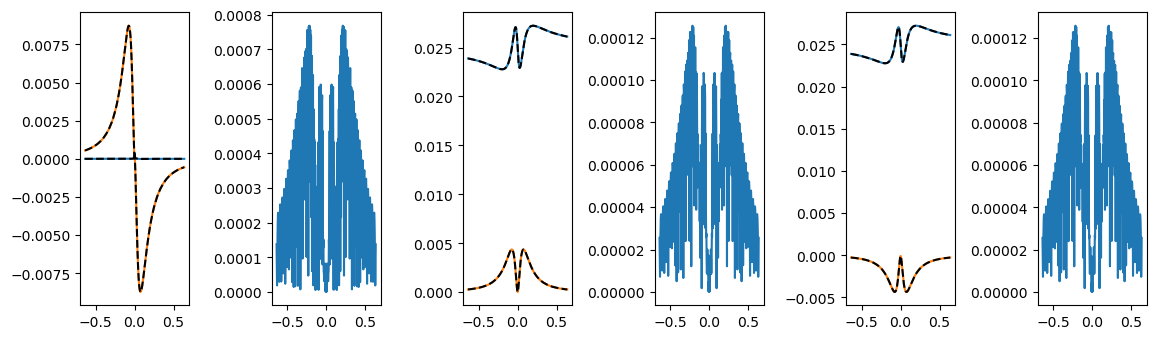

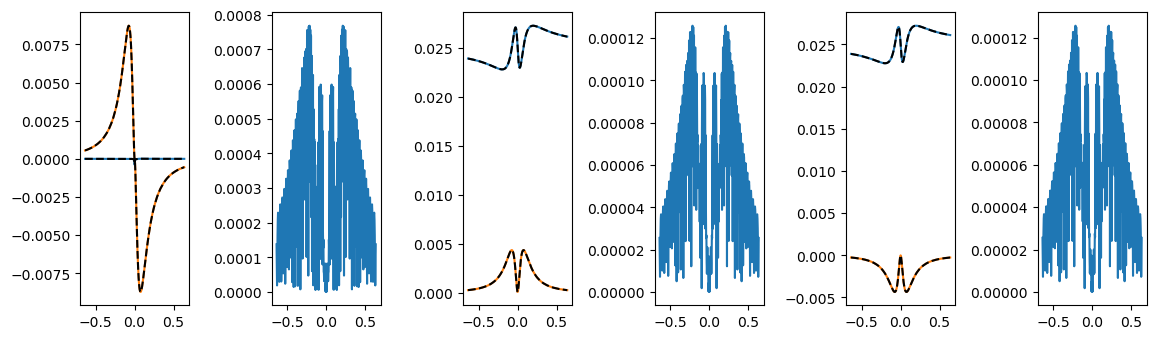

In [24]:
# LEFT
fig, axs = subplots(1,6; figsize=(PLOT_PAGE_INCH, 0.3*PLOT_PAGE_INCH))

window = 1:401
cc = 0
for ik in [(1,1), (2,1), (1,2)]
    SE_act = Σs[1][1+length(omsig)*cc:(cc+1)*length(omsig)]
    axs[0+2*cc].plot(omsig[window], real.(SE_act[window]); label="SE1")
    axs[0+2*cc].plot(omsig[window], imag.(SE_act[window]); label="SE1")
    axs[0+2*cc].plot(omsig[window], real.(SELJ[window,ik...]); label="SELJ", linestyle="--", color="black")
    axs[0+2*cc].plot(omsig[window], imag.(SELJ[window,ik...]); label="SELJ", linestyle="--", color="black")
    axs[1+2*cc].plot(omsig[window], abs.((SE_act .- SELJ[:,ik...])[window]) ./ maximum(abs.(SE_act)))
    cc += 1
end
fig.tight_layout()
display(fig)

# RIGHT
fig, axs = subplots(1,6; figsize=(PLOT_PAGE_INCH, 0.3*PLOT_PAGE_INCH))
cc = 0
for ik in [(1,1), (2,1), (1,2)]
    SE_act = Σs[2][1+length(omsig)*cc:(cc+1)*length(omsig)]
    axs[0+2*cc].plot(omsig[window], real.(SE_act[window]); label="SE1")
    axs[0+2*cc].plot(omsig[window], imag.(SE_act[window]); label="SE1")
    axs[0+2*cc].plot(omsig[window], real.(SERJ[window,ik...]); label="SERJ", linestyle="--", color="black")
    axs[0+2*cc].plot(omsig[window], imag.(SERJ[window,ik...]); label="SERJ", linestyle="--", color="black")
    axs[1+2*cc].plot(omsig[window], abs.((SE_act .- SERJ[:,ik...])[window]) ./ maximum(abs.(SE_act)))
    cc += 1
end
fig.tight_layout()
display(fig)
